In [1]:
print('hello AI. I am Dismal.')

hello AI. I am Dismal.


In [2]:
# 801 1. 載入必要的Module
import tensorflow as tf
import tensorflow_hub as hub

import requests
from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np

from datetime import date
today = date.today()
ts3 = 'Dismal'


In [3]:
# 802 載入必要的Function
original_image_cache = {}

def preprocess_image(image):
  image = np.array(image)
  # reshape into shape [batch_size, height, width, num_channels]
  img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  image = tf.image.convert_image_dtype(img_reshaped, tf.float32)
  return image

def load_image_from_url(url):
  """Returns an image with shape [1, height, width, num_channels]."""
  user_agent = {'User-agent': 'Colab Sample (https://tensorflow.org)'}
  response = requests.get(img_url, headers=user_agent)
  image = Image.open(BytesIO(response.content))
  image = preprocess_image(image)
  return image

def load_image(image_url, image_size=256, dynamic_size=False, max_dynamic_size=512):
  """Loads and preprocesses images."""
  # Cache image file locally.
  if image_url in original_image_cache:
    img = original_image_cache[image_url]
  elif image_url.startswith('https://'):
    img = load_image_from_url(image_url)
  else:
    fd = tf.io.gfile.GFile(image_url, 'rb')
    img = preprocess_image(Image.open(fd))
  original_image_cache[image_url] = img
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img_raw = img
  if tf.reduce_max(img) > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  if not dynamic_size:
    img = tf.image.resize_with_pad(img, image_size, image_size)
  elif img.shape[1] > max_dynamic_size or img.shape[2] > max_dynamic_size:
    img = tf.image.resize_with_pad(img, max_dynamic_size, max_dynamic_size)
  return img, img_raw

def show_image(image, title=''):
  image_size = image.shape[1]
  w = (image_size * 6) // 320
  plt.figure(figsize=(w, w))
  plt.imshow(image[0], aspect='equal')
  plt.axis('off')
  plt.title(title)
  plt.show()


In [4]:
## 803, Select an Image Classification model

image_size = 224
dynamic_size = False

model_name = "efficientnetv2-s" 

model_handle_map = {"efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/classification/2"}

model_image_size_map = {"efficientnetv2-s": 384}

model_handle = model_handle_map[model_name]

print(f"Selected model: {model_name} : {model_handle}")

max_dynamic_size = 512
if model_name in model_image_size_map:
  image_size = model_image_size_map[model_name]
  dynamic_size = False
  print(f"Images will be converted to {image_size}x{image_size}")
else:
  dynamic_size = True
  print(f"Images will be capped to a max size of {max_dynamic_size}x{max_dynamic_size}")

labels_file = "https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt"

#download labels and creates a maps
downloaded_file = tf.keras.utils.get_file("labels.txt", origin=labels_file)

classes = []
i = 0
with open(downloaded_file) as f:
  labels = f.readlines()
  classes = [l.strip() for l in labels[1:]]
  i += 1


Selected model: efficientnetv2-s : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/classification/2
Images will be converted to 384x384
24576/10484 [======================================================================] - 0s 0us/step


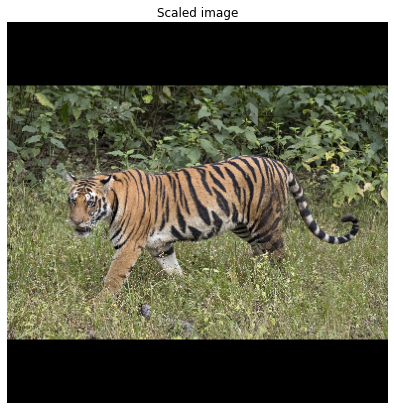

In [15]:
## 804 選項: ['tiger', 'bus', 'car', 'cat', 'dog', 'apple', 'turtle', 'flamingo', 'piano', 'honeycomb', 'teapot']
"""## 3. 選擇圖像: 您可以選擇以下圖像之一，或使用您自己的圖像。 請記住，模型的輸入大小各不相同，其中一些使用動態輸入大小（啟用對未縮放圖像的推斷）。 鑑於此，方法 load_image 已經將圖像重新縮放為預期格式。

選項: ['老虎'，'公共汽車'，'汽車'，'貓'，'狗'，'蘋果'，'烏龜'，'火烈鳥'，'鋼琴'，'蜂窩'，'茶壺']
param ['tiger', 'bus', 'car', 'cat', 'dog', 'apple', 'turtle', 'flamingo', 'piano', 'honeycomb', 'teapot']
"""



image_name = 'tiger' 

images_for_test_map = {
    "tiger": "https://upload.wikimedia.org/wikipedia/commons/b/b0/Bengal_tiger_%28Panthera_tigris_tigris%29_female_3_crop.jpg",
    "bus": "https://upload.wikimedia.org/wikipedia/commons/6/63/LT_471_%28LTZ_1471%29_Arriva_London_New_Routemaster_%2819522859218%29.jpg",
    "car": "https://upload.wikimedia.org/wikipedia/commons/4/49/2013-2016_Toyota_Corolla_%28ZRE172R%29_SX_sedan_%282018-09-17%29_01.jpg",
    "cat": "https://upload.wikimedia.org/wikipedia/commons/4/4d/Cat_November_2010-1a.jpg",
    "dog": "https://upload.wikimedia.org/wikipedia/commons/archive/a/a9/20090914031557%21Saluki_dog_breed.jpg",
    "apple": "https://upload.wikimedia.org/wikipedia/commons/1/15/Red_Apple.jpg",
    "turtle": "https://upload.wikimedia.org/wikipedia/commons/8/80/Turtle_golfina_escobilla_oaxaca_mexico_claudio_giovenzana_2010.jpg",
    "flamingo": "https://upload.wikimedia.org/wikipedia/commons/b/b8/James_Flamingos_MC.jpg",
    "piano": "https://upload.wikimedia.org/wikipedia/commons/d/da/Steinway_%26_Sons_upright_piano%2C_model_K-132%2C_manufactured_at_Steinway%27s_factory_in_Hamburg%2C_Germany.png",
    "honeycomb": "https://upload.wikimedia.org/wikipedia/commons/f/f7/Honey_comb.jpg",
    "teapot": "https://upload.wikimedia.org/wikipedia/commons/4/44/Black_tea_pot_cropped.jpg",
}

img_url = images_for_test_map[image_name]
image, original_image = load_image(img_url, image_size, dynamic_size, max_dynamic_size)
show_image(image, 'Scaled image')



In [11]:
## 805 加載 TensorFlow Hub!
classifier = hub.load(model_handle)

input_shape = image.shape
warmup_input = tf.random.uniform(input_shape, 0, 1.0)



CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.39 µs
(1)  292 - tiger: 0.7570312023162842 ,  tiger
(2)  282 - tiger cat: 0.15417741239070892 ,  tiger cat
(3)  290 - jaguar: 0.0022564970422536135 ,  jaguar
(4)  281 - tabby: 0.0009737632353790104 ,  tabby
(5)  287 - lynx: 0.0009310820605605841 ,  lynx


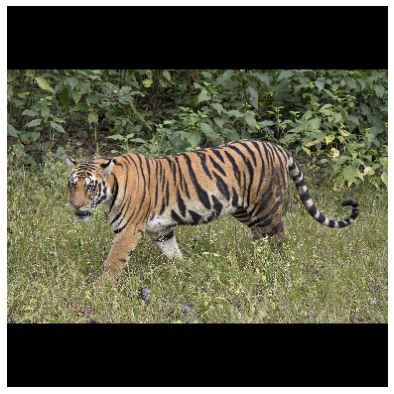

In [17]:
## 806 在圖像上運行模型 (Run model on image)
# 
%time 
probabilities = tf.nn.softmax(classifier(image)).numpy()

top_5 = tf.argsort(probabilities, axis=-1, direction="DESCENDING")[0][:5].numpy()
np_classes = np.array(classes)
includes_background_class = probabilities.shape[1] == 1001

for i, item in enumerate(top_5):
  class_index = item if not includes_background_class else item - 1
  line = f'({i+1}) {class_index:4} - {classes[class_index]}: {probabilities[0][top_5][i]}'
  translation = classes[class_index]
  print(line, ', ', translation)

show_image(image, '')

In [13]:
## 808 實作A:  Python自動翻譯功能Module測試
!pip install translate # 安裝翻譯模組
from translate import Translator
E_2_TW = Translator(to_lang="zh-TW") # 英翻中
print('完成安裝與載入翻譯模組 at %s.Thanks!' % today)

## Method 1 without loop
print('*** Method 1 without loop')
ts1, ts2 = 'computer', 'university'
translation1 = E_2_TW.translate(ts1)
print('1',ts1, translation1)
translation2 = E_2_TW.translate(ts2)
print('2',ts2, translation2)
translation3 = E_2_TW.translate(ts3) 
print('3',ts3, translation3)

## Method 2 with Loop
print('*** Method 2 with Loop')
explist = [ts1, ts2, ts3]
for i, ts in enumerate(explist):
  result = E_2_TW.translate(ts)
  print(i, ts, result)

print('*** Done by %s at ' % ts3,today, type(today))


完成安裝與載入翻譯模組 at 2021-11-28.Thanks!
*** Method 1 without loop
1 computer 電腦
2 university 大學
3 Dismal 可憐哪
*** Method 2 with Loop
0 computer 電腦
1 university 大學
2 Dismal 可憐哪
*** Done by Dismal at  2021-11-28 <class 'datetime.date'>


CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.3 µs
(1)  292 - tiger: 0.7570312023162842 ,  老虎
(2)  282 - tiger cat: 0.15417741239070892 ,  虎貓
(3)  290 - jaguar: 0.0022564970422536135 ,  Jaguar
(4)  281 - tabby: 0.0009737632353790104 ,  虎斑貓
(5)  287 - lynx: 0.0009310820605605841 ,  猞猁


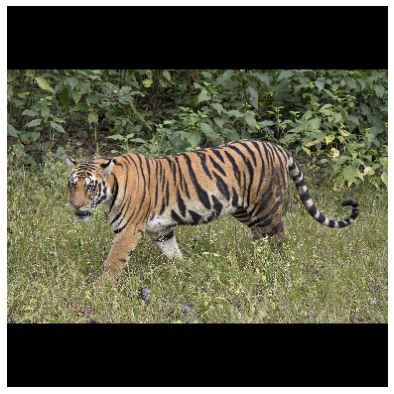

In [16]:
# 809 實作B: 在圖像上運行模型
# 
%time 

probabilities = tf.nn.softmax(classifier(image)).numpy()

top_5 = tf.argsort(probabilities, axis=-1, direction="DESCENDING")[0][:5].numpy()
np_classes = np.array(classes)
includes_background_class = probabilities.shape[1] == 1001

for i, item in enumerate(top_5):
  class_index = item if not includes_background_class else item - 1
  line = f'({i+1}) {class_index:4} - {classes[class_index]}: {probabilities[0][top_5][i]}'
  translation1 = E_2_TW.translate(classes[class_index])
  print(line, ', ', translation1)

show_image(image, '')

實作C: 從已提供的選項中,找一張自己喜歡的照片來試試看

(1)  282 - tiger cat: 0.35764557123184204 ,  虎貓
(2)  281 - tabby: 0.3533194661140442 ,  虎斑貓
(3)  285 - Egyptian cat: 0.18555432558059692 ,  埃及貓
(4)  287 - lynx: 0.009140240028500557 ,  猞猁
(5)  292 - tiger: 0.0013132060412317514 ,  老虎


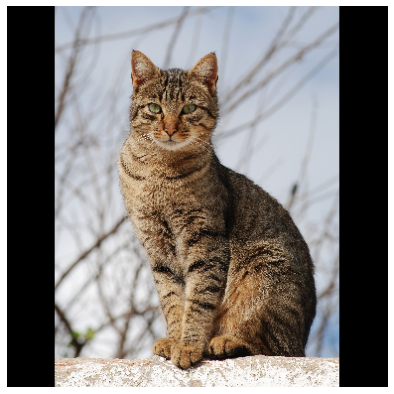

In [20]:
# 實作C: 從已提供的選項中,找一張自己喜歡的照片來試試看
image_name = "cat"

img_url = images_for_test_map[image_name]
image, original_image = load_image(img_url, image_size, dynamic_size, max_dynamic_size)
probabilities = tf.nn.softmax(classifier(image)).numpy()

top_5 = tf.argsort(probabilities, axis=-1, direction="DESCENDING")[0][:5].numpy()
np_classes = np.array(classes)
includes_background_class = probabilities.shape[1] == 1001

for i, item in enumerate(top_5):
  class_index = item if not includes_background_class else item - 1
  line = f'({i+1}) {class_index:4} - {classes[class_index]}: {probabilities[0][top_5][i]}'
  translation1 = E_2_TW.translate(classes[class_index])
  print(line, ', ', translation1)

show_image(image, '')

實作D (Optional): 從網路上找一張自己喜歡的照片來試試看 (jpg/png)

(1)  269 - timber wolf: 0.7329260110855103 ,  大灰狼
(2)  271 - red wolf: 0.10620227456092834 ,  紅狼
(3)  272 - coyote: 0.0687934160232544 ,  郊狼
(4)  270 - white wolf: 0.010681002400815487 ,  白狼
(5)  280 - grey fox: 0.004756120499223471 ,  灰狐狸


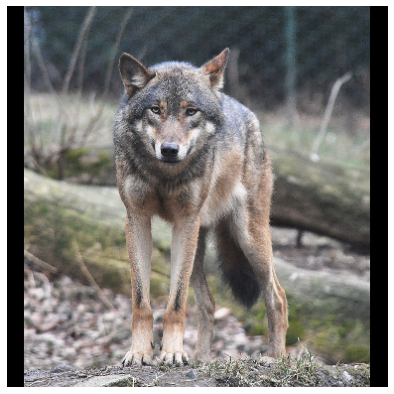

In [26]:
# 實作D (Optional): 從網路上找一張自己喜歡的照片來試試看 (jpg/png)
image_name = "wolf"
images_for_test_map['wolf'] = "https://upload.wikimedia.org/wikipedia/commons/a/ab/European_grey_wolf_in_Prague_zoo.jpg"

img_url = images_for_test_map[image_name]
image, original_image = load_image(img_url, image_size, dynamic_size, max_dynamic_size)
probabilities = tf.nn.softmax(classifier(image)).numpy()

top_5 = tf.argsort(probabilities, axis=-1, direction="DESCENDING")[0][:5].numpy()
np_classes = np.array(classes)
includes_background_class = probabilities.shape[1] == 1001

for i, item in enumerate(top_5):
  class_index = item if not includes_background_class else item - 1
  line = f'({i+1}) {class_index:4} - {classes[class_index]}: {probabilities[0][top_5][i]}'
  translation1 = E_2_TW.translate(classes[class_index])
  print(line, ', ', translation1)

show_image(image, '')